<a href="https://colab.research.google.com/github/CFA-Institute-RPC/Synthetic-Data-For-Finance/blob/main/LLM/01-Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
In this notebook we perform some preprocessing and exploratory data analysis. Namely, we:

1) Download the FiQA-SA training, validation and test datasets

2) Explore the data a little bit - which companies are included, what is the distribution of sentiment scores?

3) Group the continuous sentiment scores into the three classification labels, negative, positive and neutral

4) Save the resulting datasets

# What is FiQA-SA?

FiQA-SA is an open-source dataset containing sentiment labels on a diverse range of financial texts sourced from news articles and tweets. Each sentence has been labelled with a continuous sentiment score for a particular company ranging from [-1, 1], where -1 is most negative and 1 is most positive.

The dataset includes 822 training samples, 117 validation and 234 testing samples.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Define paths to training, validation and test splits
splits = {'train': 'data/train-00000-of-00001-aeefa1eadf5be10b.parquet', 'test': 'data/test-00000-of-00001-0fb9f3a47c7d0fce.parquet', 'valid': 'data/valid-00000-of-00001-51867fe1ac59af78.parquet'}

# Load each dataset
train = pd.read_parquet("hf://datasets/TheFinAI/fiqa-sentiment-classification/" + splits["train"])
val = pd.read_parquet("hf://datasets/TheFinAI/fiqa-sentiment-classification/" + splits["valid"])
test = pd.read_parquet("hf://datasets/TheFinAI/fiqa-sentiment-classification/" + splits["test"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# View the first few rows
train.head()

,_id,sentence,target,aspect,score,type
0,1,Royal Mail chairman Donald Brydon set to step ...,Royal Mail,Corporate/Appointment,-0.374,headline
1,100,Slump in Weir leads FTSE down from record high,Weir,Market/Volatility/Volatility,-0.827,headline
2,1000,AstraZeneca wins FDA approval for key new lung...,AstraZeneca,Corporate/Regulatory,0.549,headline
3,1002,UPDATE 1-Lloyds to cut 945 jobs as part of 3-y...,Lloyds,Corporate/Strategy,-0.266,headline
4,1005,Standard Chartered Shifts Emerging-Markets Str...,Standard Chartered,Corporate/Strategy,-0.461,headline


Text(0.5, 1.0, 'Top 20 common companies in training dataset')

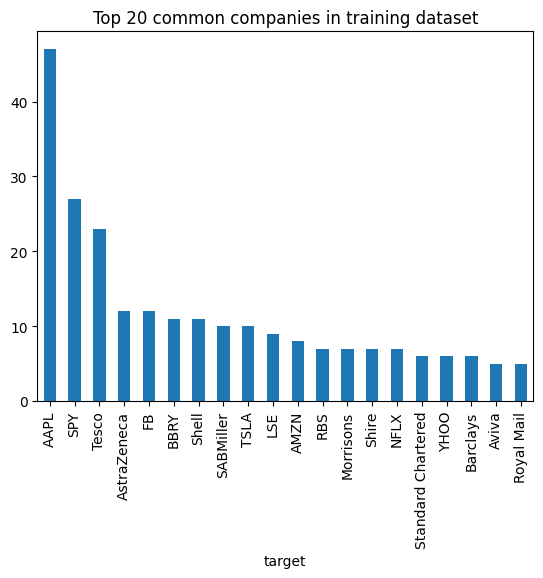

In [ ]:
import matplotlib.pyplot as plt
# View the top companies mentioned in the training data

train['target'].value_counts()[:20].plot(kind='bar')
plt.title('Top 20 common companies in training dataset')


We can see that Apple (AAPL) has the most sentences in the dataset, followed by SPY and Tesco.

Text(0.5, 1.0, 'Distribution of sentiment scores across the training dataset')

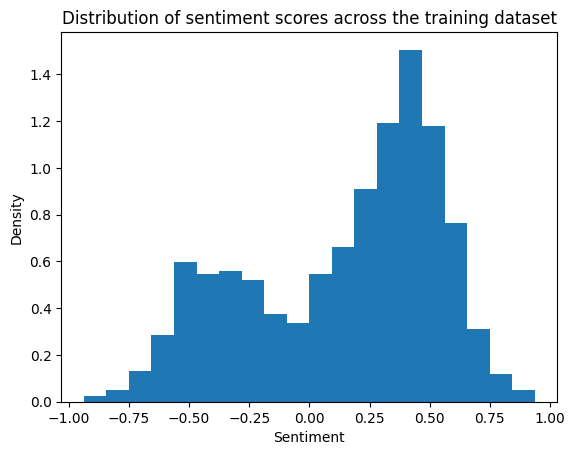

In [ ]:
# View the distribution of sentiment scores
import matplotlib.pyplot as plt
plt.hist(train['score'],density=True,bins=20)
plt.xlabel('Sentiment')
plt.ylabel('Density')
plt.title('Distribution of sentiment scores across the training dataset')


We see  most sentiment labels are positive (sentiment >0). When performing sentiment analysis, LLMs are typically less accurate at assigning continuous values compared to categorical labels. As a result, for our analysis we will categorize the sentiment into three classes, positive (>0), negative (<0) and neutral (=0). We will fine-tune our Qwen3 models to correctly predict the sentiment class for each sentence.

In [ ]:
# Create function classifying sentiment into positive, neutral or negative
def classify_sentiment(score):
    if score > 0:
        return 3
    elif score < 0:
        return 1
    else:
        return 2

In [ ]:
# Apply the function to each row and save the results in new 'label' columns
train['label'] = train['score'].apply(classify_sentiment)
val['label'] = val['score'].apply(classify_sentiment)
test['label'] = test['score'].apply(classify_sentiment)


In [ ]:
train.head() # We now have a new 'label' column

,_id,sentence,target,aspect,score,type,label
0,1,Royal Mail chairman Donald Brydon set to step ...,Royal Mail,Corporate/Appointment,-0.374,headline,1
1,100,Slump in Weir leads FTSE down from record high,Weir,Market/Volatility/Volatility,-0.827,headline,1
2,1000,AstraZeneca wins FDA approval for key new lung...,AstraZeneca,Corporate/Regulatory,0.549,headline,3
3,1002,UPDATE 1-Lloyds to cut 945 jobs as part of 3-y...,Lloyds,Corporate/Strategy,-0.266,headline,1
4,1005,Standard Chartered Shifts Emerging-Markets Str...,Standard Chartered,Corporate/Strategy,-0.461,headline,1


In [ ]:
print(train['label'].value_counts())

label
3    546
1    264
2     12
Name: count, dtype: int64


In [ ]:
# Save the data
from pathlib import Path

#Create data folder if not already present
Path('/content/drive/MyDrive/data/').mkdir(parents=True, exist_ok=True)

# Save data to data folder
train[['sentence','score','label']].to_csv('drive/MyDrive/data/train.csv',index=False)
val[['sentence','score','label']].to_csv('drive/MyDrive/data/val.csv',index=False)
test[['sentence','score','label']].to_csv('drive/MyDrive/data/test.csv',index=False)
